In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('./ml-fairness-gym'))
if module_path not in sys.path:
    sys.path.append(module_path)

from environments import infectious_disease as id
from experiments import infectious_disease as ide
from agents import infectious_disease_agents as ida

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science", "notebook"])
# plt.style.use("default")


2022-02-28 21:02:09.995103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/evanlavender/miniconda3/envs/responsible-ml/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-28 21:02:09.995271: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Params(transition_matrix=array([[0. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ]]), treatment_transition_matrix=array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]]), state_names=['susceptible', 'infected', 'recovered'], healthy_index=0, infectious_index=1, healthy_exit_index=1, infection_probability=0.5, population_graph=<networkx.classes.graph.Graph object at 0x7fd7b069baf0>, initial_health_state=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], initial_health_state_seed=27, num_treatments=1, max_treatments=1, burn_in=0)


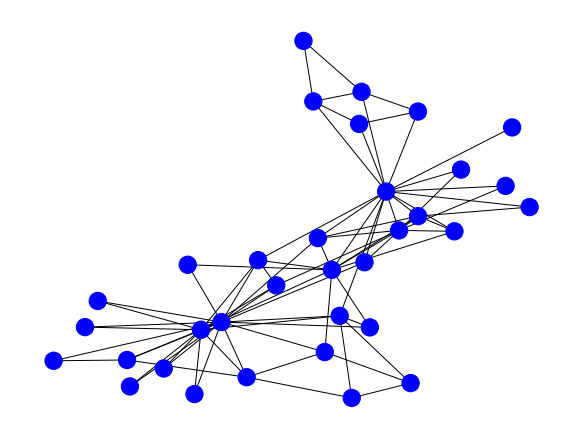

In [2]:
SEED = 13

np.random.seed(SEED)

TAU   = 0.5
RHO   = 0.5
#ide.GRAPHS["scale"] = nx.generators.random_internet_as_graph(100)
# ide.GRAPHS["scale"] = nx.Graph(nx.generators.scale_free_graph(250, seed=SEED).to_undirected())
# G = ide.GRAPHS["scale"]
# G.remove_edges_from(nx.selfloop_edges(G))

EXP = ide.Experiment()
EXP.graph_name = "karate"
EXP.infection_probability     = TAU
EXP.infected_exit_probability = RHO
EXP.num_treatments = 1
EXP.burn_in = 0
EXP.agent_constructor = ide.NullAgent
EXP.scenario_builder()
print(EXP.env.initial_params)

positions = nx.spring_layout(EXP.env.initial_params.population_graph, seed=SEED)
color_map = ["blue", "red", "purple"]
EXP.env.render(color_map, pos=positions)

In [3]:
from tqdm import trange

def _num_sickdays(states):
    n = np.zeros(states.shape[1], dtype=int)
    for i in range(states.shape[1]):
        col = states[:, i]
        n[i] = np.count_nonzero(col == 1)
    return n

def process_metrics(i, metrics, results):
    states = np.array(results["states"])
    num_sickdays = _num_sickdays(states)
    total_sickdays = np.sum(num_sickdays)
    metrics["num_sickdays"] += num_sickdays
    metrics["total_sickdays"] += total_sickdays

def run_simulations(n_sims, exp):
    size = ide.GRAPHS[exp.graph_name].number_of_nodes()
    metrics = {
        "num_sickdays": np.zeros(size),
        "total_sickdays": 0
    }

    exp.scenario_builder()
    for i in trange(n_sims):
        exp.seed = i
        # np.random.seed(i)
        r = exp.run()
        process_metrics(i, metrics, r["metric_results"])
    return metrics

In [28]:
EXP.num_steps = 20
N = 100

EXP.agent_constructor = ide.NullAgent
null_metrics = run_simulations(N, EXP)

EXP.agent_constructor = ida.RandomNeighbor
rnbr_metrics = run_simulations(N, EXP)

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


In [29]:
EXP.agent_constructor = ida.CentralityAgent
ida.CENTRALITY_FUNCION = nx.centrality.degree_centrality
deg_metrics = run_simulations(N, EXP)

ida.CENTRALITY_FUNCION = nx.centrality.eigenvector_centrality
eig_metrics = run_simulations(N, EXP)

ida.CENTRALITY_FUNCION = nx.centrality.betweenness_centrality
btw_metrics = run_simulations(N, EXP)

100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


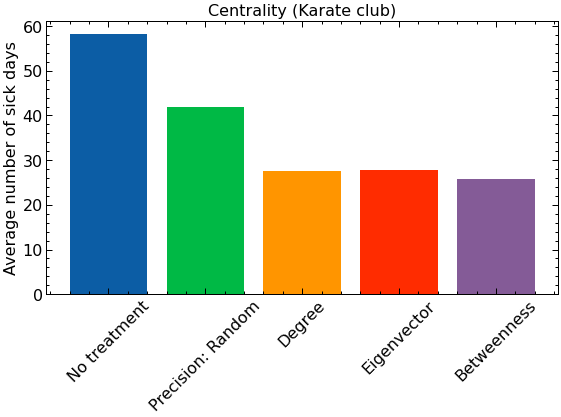

In [30]:
metrics = [null_metrics, rnbr_metrics, deg_metrics, eig_metrics, btw_metrics]
labels = ["No treatment", "Precision: Random", "Degree", "Eigenvector", "Betweenness"]

plt.figure()
plt.title("Centrality (Karate club)")
plt.ylabel("Average number of sick days")
plt.xticks(rotation=45)
for metric, label in zip(metrics, labels):
    total_sickdays = metric["total_sickdays"] / N
    plt.bar(label, total_sickdays)
plt.tight_layout()
plt.savefig("out/nb-karate-sickdays.jpg")
plt.show()

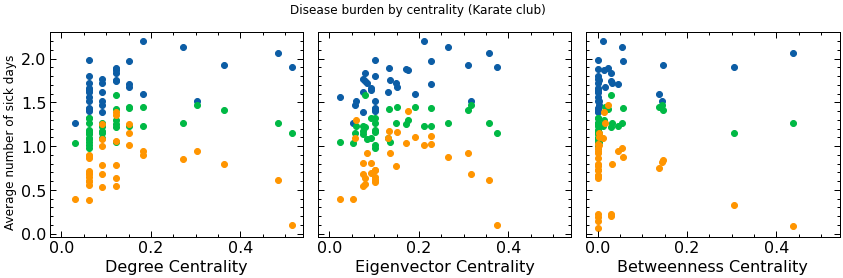

In [31]:
G = ide.GRAPHS["karate"]
deg_cent = nx.centrality.degree_centrality(G).values()
eig_cent = nx.centrality.eigenvector_centrality(G).values()
btw_cent = nx.centrality.betweenness_centrality(G).values()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("Disease burden by centrality (Karate club)")
fig.supylabel("Average number of sick days")
axes[0].set_xlabel("Degree Centrality")
axes[0].scatter(deg_cent, null_metrics["num_sickdays"] / N, label="No treatment")
axes[0].scatter(deg_cent, rnbr_metrics["num_sickdays"] / N, label="Precision: Random")
axes[0].scatter(deg_cent, deg_metrics["num_sickdays"] / N, label="Centrality")
axes[1].set_xlabel("Eigenvector Centrality")
axes[1].scatter(eig_cent, null_metrics["num_sickdays"] / N, label="No treatment")
axes[1].scatter(eig_cent, rnbr_metrics["num_sickdays"] / N, label="Precision: Random")
axes[1].scatter(eig_cent, eig_metrics["num_sickdays"] / N, label="Centrality")
axes[2].set_xlabel("Betweenness Centrality")
axes[2].scatter(btw_cent, null_metrics["num_sickdays"] / N, label="No treatment")
axes[2].scatter(btw_cent, rnbr_metrics["num_sickdays"] / N, label="Precision: Random")
axes[2].scatter(btw_cent, btw_metrics["num_sickdays"] / N, label="Centrality")
# handles, labels = axes[2].get_legend_handles_labels()
# fig.legend(handles, labels, loc=(1, 0))
fig.tight_layout()
fig.savefig("out/nb-karate-centrality.jpg")

In [32]:
G = ide.GRAPHS["karate"]
print(list(G.neighbors(0)))

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
